In [116]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from dataclasses import replace
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from loguru import logger

from utils.omen_utils import load_data_into_omen_dataset
from omen import OMEN

logger.remove()
logger.add(sys.stderr, level=1);


Found 20 training paths and 0 validation paths
Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left
Reorder this dataset alex_kovalev_standart_elbow_left True
(8, 47424) (20, 47424)
Added session alex_kovalev_standart_elbow_left with 379 trials


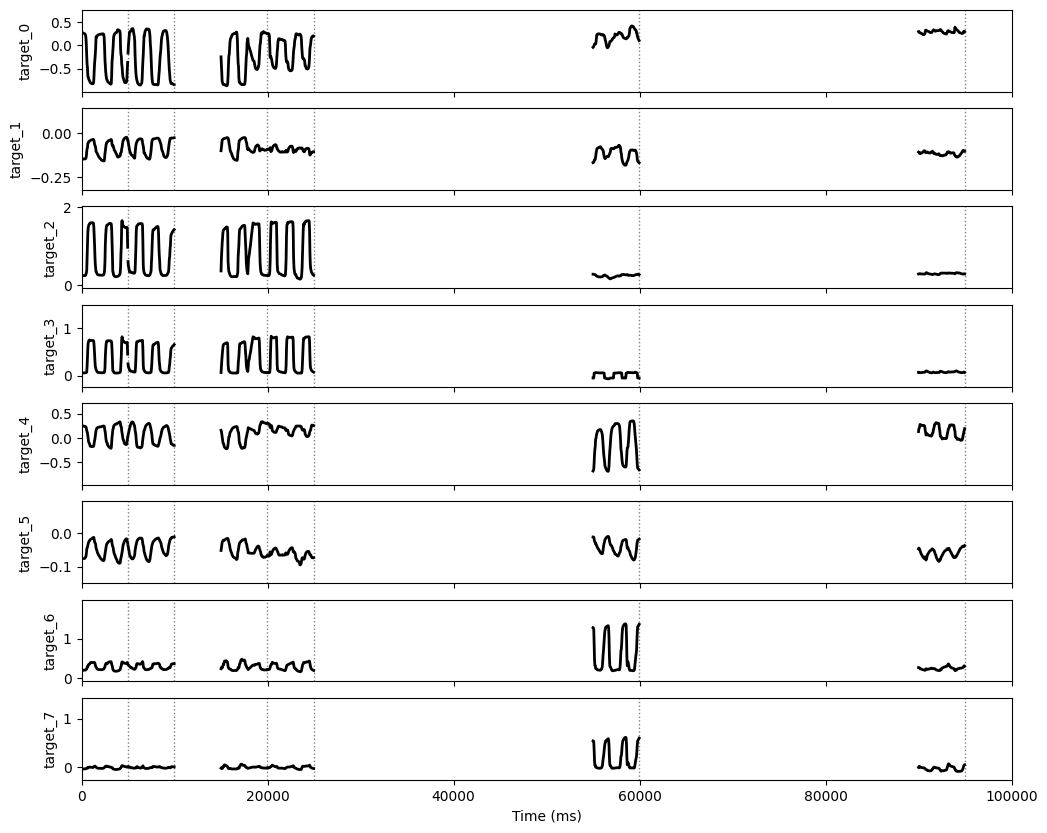

In [117]:
omen_ds = load_data_into_omen_dataset(1)

_, ax = omen_ds.sessions[0].visualize(max_n_trials=30);
ax.set(xlim=[0, 1e5]);

# Train OMEN

Train OMEN

2024-07-30 09:50:16.670 | DEBUG_LOW | omen.omen:build:67 - Building OMEN - encoder input dimension: 8
2024-07-30 09:50:16.690 | DEBUG    | omen.omen:fit_session:249 - Fitting OMEN with a single session: alex_kovalev_standart_elbow_left
2024-07-30 09:50:16.692 | DEBUG_LOW | omen.lookup.lut:on_fit_start:90 - Fitting Y scalers on 47250 samples - 20 dimensions | 1 sessions
2024-07-30 09:50:16.700 | DEBUG_LOW | omen.lookup.session:populate:93 - Populating alex_kovalev_standart_elbow_left session lookup.
2024-07-30 09:50:17.643 | DEBUG    | omen.train.base_trainer:__init__:51 - 
Trainer SingleSessionTrainer created with 
LUT(n sessions: 1, embedding size: 256)
	* alex_kovalev_standart_elbow_left 
and
Portent
	Encoder: tCNN: 8 |> 64 > 64 |> 64 -  leaky_relu, 1 kernels, kernel_size: 1
	Heads:
		0: MLP: 64 |> 48 |> 48 - leaky_relu
		1: MLP: 64 |> 48 |> 48 - leaky_relu
		2: MLP: 64 |> 48 |> 48 - leaky_relu
		3: MLP: 64 |> 48 |> 48 - leaky_relu
		4: MLP: 64 |> 48 |> 48 - leaky_relu
		5: MLP: 64 |

Output()

2024-07-30 09:52:34.977 | DEBUG_LOW | omen.train.base_trainer:train:180 - Training interrupted
2024-07-30 09:52:34.997 | GPU      | omen.train.device_manager:unload:82 - Unloading all models
2024-07-30 09:52:35.005 | REFINE   | omen.omen:refine_cans:95 - Refining CAN hyperparameters
2024-07-30 09:52:35.006 | REFINE   | omen.omen:refine_cans:105 - session 1/1
2024-07-30 09:52:35.098 | REFINE   | omen.omen:refine_cans:116 -   CAN 1/20
2024-07-30 09:52:38.362 | REFINE   | omen.can:refine:257 - refined beta - 5.000 -> 2.500 || loss: 0.01949 -> 0.01927
2024-07-30 09:52:41.413 | REFINE   | omen.can:refine:257 - refined sigma - 0.250 -> 0.208 || loss: 0.01927 -> 0.01924
2024-07-30 09:52:41.413 | REFINE   | omen.omen:refine_cans:116 -   CAN 2/20
2024-07-30 09:52:44.413 | REFINE   | omen.can:refine:257 - refined beta - 5.000 -> 2.500 || loss: 0.00672 -> 0.00669
2024-07-30 09:52:47.607 | REFINE   | omen.can:refine:257 - refined sigma - 0.250 -> 0.125 || loss: 0.00669 -> 0.00666
2024-07-30 09:52:


=== OMEN ===
Portent: Portent
	Encoder: tCNN: 8 |> 64 > 64 |> 64 -  leaky_relu, 1 kernels, kernel_size: 1
	Heads:
		0: MLP: 64 |> 48 |> 48 - leaky_relu
		1: MLP: 64 |> 48 |> 48 - leaky_relu
		2: MLP: 64 |> 48 |> 48 - leaky_relu
		3: MLP: 64 |> 48 |> 48 - leaky_relu
		4: MLP: 64 |> 48 |> 48 - leaky_relu
		5: MLP: 64 |> 48 |> 48 - leaky_relu
		6: MLP: 64 |> 48 |> 48 - leaky_relu
		7: MLP: 64 |> 48 |> 48 - leaky_relu
		8: MLP: 64 |> 48 |> 48 - leaky_relu
		9: MLP: 64 |> 48 |> 48 - leaky_relu
		10: MLP: 64 |> 48 |> 48 - leaky_relu
		11: MLP: 64 |> 48 |> 48 - leaky_relu
		12: MLP: 64 |> 48 |> 48 - leaky_relu
		13: MLP: 64 |> 48 |> 48 - leaky_relu
		14: MLP: 64 |> 48 |> 48 - leaky_relu
		15: MLP: 64 |> 48 |> 48 - leaky_relu
		16: MLP: 64 |> 48 |> 48 - leaky_relu
		17: MLP: 64 |> 48 |> 48 - leaky_relu
		18: MLP: 64 |> 48 |> 48 - leaky_relu
		19: MLP: 64 |> 48 |> 48 - leaky_relu

CANs:
	0: CAN Line > Cell(N: 48, beta: 2.5000, sigma: 0.2083, tau: 1.5)
	1: CAN Line > Cell(N: 48, beta: 2.5000, s

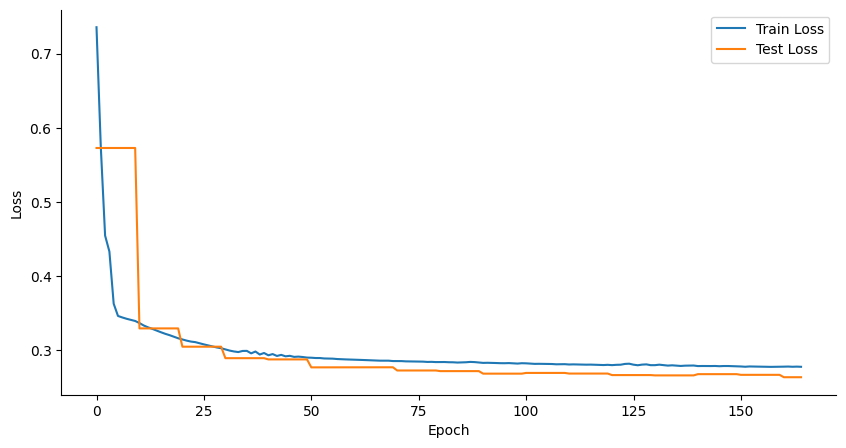

In [114]:
omen_config = dict(
    activation= 'leaky_relu',
    beta= 2.5,
    embedding_dim= 64,
    head_n_layers= 1,
    input_sigma= 0.25,
    kernel_size= 5,
    lr= 0.0075,
    n_epochs= 250,
    n_hidden= 64,
    n_kernels= 1,
    n_layers= 2,
    sigma= 0.25,
)


betas = [4, 8, 8, 4, 4, 4, 4, 4]
sigmas = [1, 1, 1, 1, 0.5, 1, 1, 0.5]

# create and fit
omen = OMEN.from_config(omen_config)
omen.fit_session(
    omen_ds.sessions[0], plot_history=True, verbose=True, should_refine=False
)

# refine CAN hps
# for i, (beta, sigma) in enumerate(zip(betas, sigmas)):
#     omen.cans[i].initial_params = {'beta': beta, 'sigma': sigma}
#     omen.cans[i].cell.tau = 1.2

# for can in omen.cans:
#     can.initial_params = {'beta': 8, 'sigma': 0.25}
#     can.cell.beta = 8

# omen.refine_cans(verbose=True)
omen

In [78]:
# omen.predict_session(omen_ds.sessions[0], trial_set='train')
# omen_ds.sessions[0].visualize(max_n_trials=50);

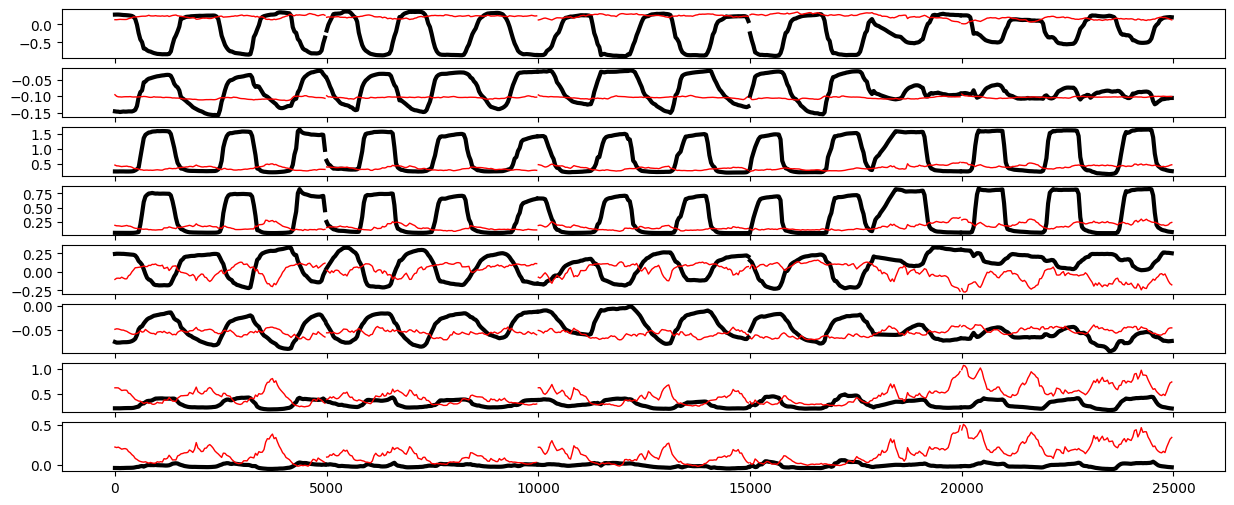

In [118]:
n_to_plot=8


f, axes = plt.subplots(n_to_plot, 1, figsize=(15, 6), sharex=True)

starts = [trial.time[0] for trial in omen_ds.sessions[0].train_trials]
sorted_trials = [trial for _, trial in sorted(zip(starts, omen_ds.sessions[0].train_trials))]

for trial in sorted_trials[:5]:
    sd = omen.lut[omen_ds.sessions[0].name]
    trial.Ypred = omen.predict(
        sd.on_predict_start(
                        trial.X, do_ue=False
                    )
    )

    for i in range(n_to_plot):
        axes[i].plot(trial.time, trial.Y[:, i], label='true', color='k', lw=3)
        axes[i].plot(trial.time, trial.Ypred[:, i], label='pred', color='r', lw=1)
